In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", font_scale=2)

In [2]:
# Constants
tau_m = 0.030
current = 1.5
vreset = -1
vth = 1
duration = 0.125
dt = 0.0001
time = np.arange(0, duration, dt)

In [3]:
def run_simul():
    mem_pot = [vreset]
    spikes = []
    for t in time[1:]:
        new_mem_pot = mem_pot[-1] + (current - mem_pot[-1]) * dt / tau_m
        if new_mem_pot > vth:
            new_mem_pot = vreset
            spikes.append(t)
        mem_pot.append(new_mem_pot)
    mem_pot, spikes = np.array(mem_pot), np.array(spikes)
    return mem_pot, spikes

In [4]:
mem_pot, spikes = run_simul()

In [5]:
spikes[0]

0.0483

In [6]:
-tau_m*np.log((1-current)/(-1-current))

0.048283137373023005

In [7]:
current+np.sqrt(current**2-1), current-np.sqrt(current**2-1)

(2.618033988749895, 0.3819660112501051)

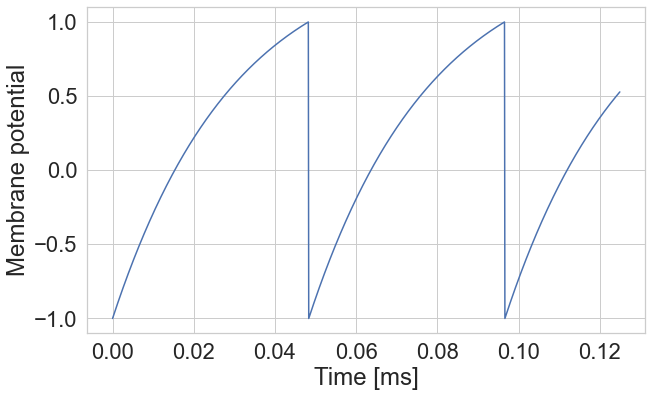

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(time, mem_pot)
plt.xlabel("Time [ms]")
plt.ylabel("Membrane potential");
plt.savefig("vdsp_maths_mem_pot.svg", bbox_inches="tight")

$$
\Delta_t = \tau_m \cdot \min\{|\ln(\frac{v_{\text{th}} - I}{v(t_{\text{post}})-I})|, |\ln(\frac{v_{\text{reset}} - I}{v(t_{\text{post}})-I})|\}
$$

In [9]:
dtn = np.log((vth - current) / (mem_pot - current))
dtp = np.log((vreset - current) / (mem_pot - current))
dts = tau_m*np.min((np.abs(dtn), np.abs(dtp)), axis=0)
signs = np.sign(np.diff(dts))
signed_dts = signs*dts[:-1]

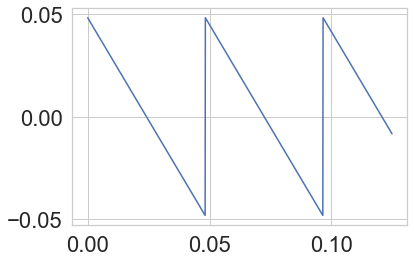

In [10]:
plt.plot(time, -(tau_m*dtp+tau_m*dtn))

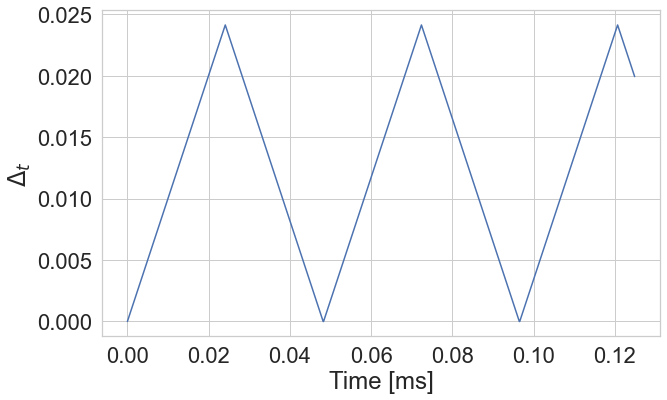

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(time, dts)
plt.xlabel("Time [ms]")
plt.ylabel("$\Delta_t$")
plt.savefig("vdsp_maths_time_vs_dt.svg", bbox_inches="tight");

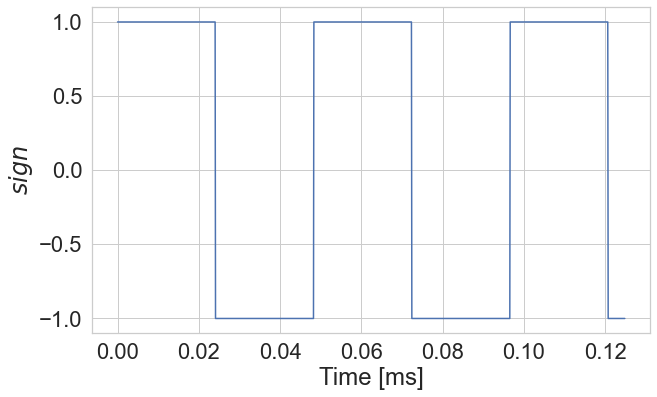

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(time[:-1], signs)
plt.xlabel("Time [ms]")
plt.ylabel("$sign$")
plt.savefig("vdsp_maths_time_vs_signs.svg", bbox_inches="tight");

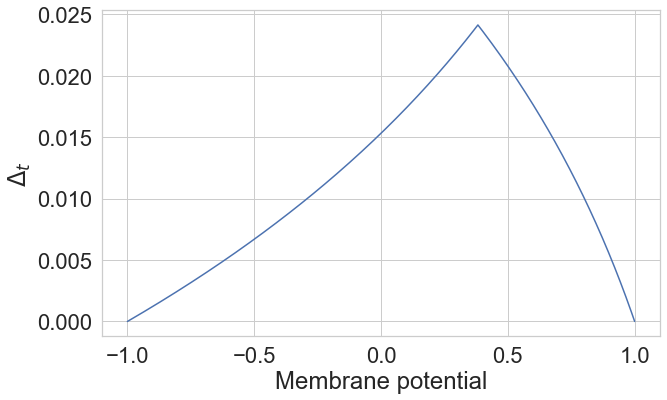

In [13]:
sorted_x, sorted_y = zip(*sorted(zip(mem_pot, dts)))
plt.figure(figsize=(10, 6))
plt.plot(sorted_x, sorted_y)
plt.xlabel("Membrane potential")
plt.ylabel("$\Delta_t$");
plt.savefig("vdsp_maths_mem_pot_vs_dt.svg", bbox_inches="tight")

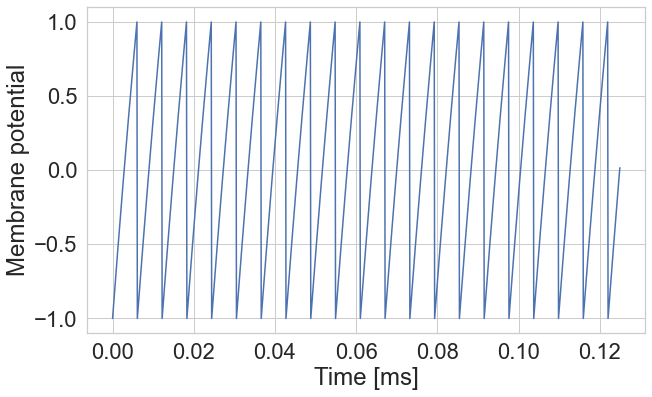

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(time, mem_pot)
plt.xlabel("Time [ms]")
plt.ylabel("Membrane potential");
plt.savefig("vdsp_maths_mem_pot.svg", bbox_inches="tight")

In [17]:
w = 0.5
dw_vdsp = (mem_pot < 0) * (np.exp(-w)*(-w+1)) * (np.exp(-mem_pot)-1) - (mem_pot > 0) * np.exp(w-1)*w*(np.exp(mem_pot)-1)

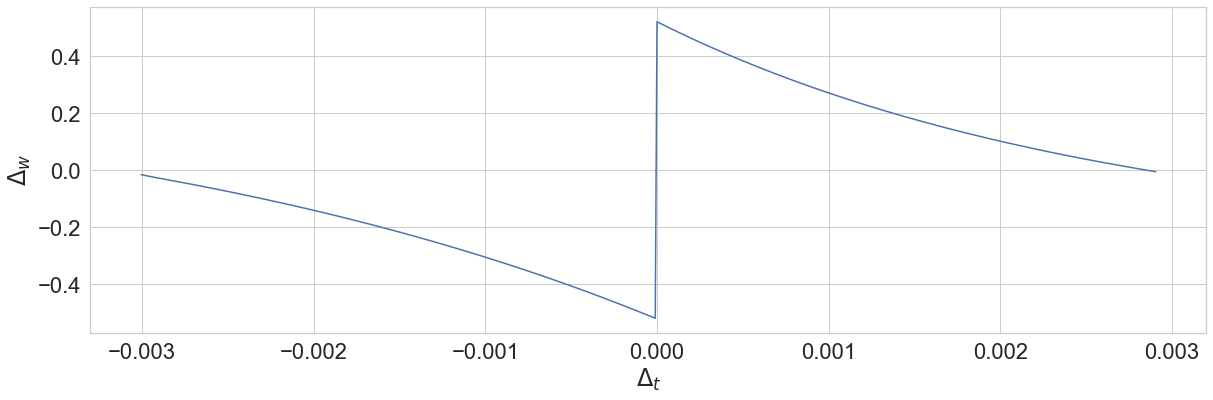

In [18]:
sorted_x, sorted_y,  = zip(*sorted(zip(signed_dts, dw_vdsp)))
plt.figure(figsize=(20, 6))
plt.plot(sorted_x, sorted_y)
plt.xlabel("$\Delta_t$")
plt.ylabel("$\Delta_w$");
plt.savefig("vdsp_maths_dt_vs_dw.svg", bbox_inches="tight")

In [19]:
tau_stdp = 0.010
frac = tau_m/tau_stdp
dw_stdp_pot = ((mem_pot-current)/(vreset-current))**frac - ((vth-current)/(mem_pot-current))**frac

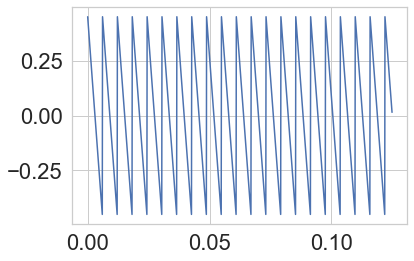

In [20]:
plt.plot(time, dw_stdp_pot)

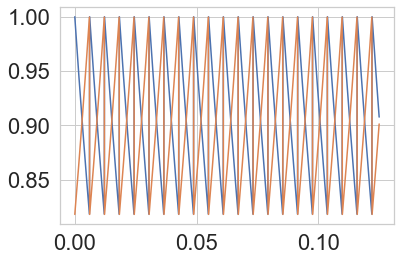

In [21]:
plt.plot(time, (mem_pot-current)/(vreset-current))
plt.plot(time, (vth-current)/(mem_pot-current))

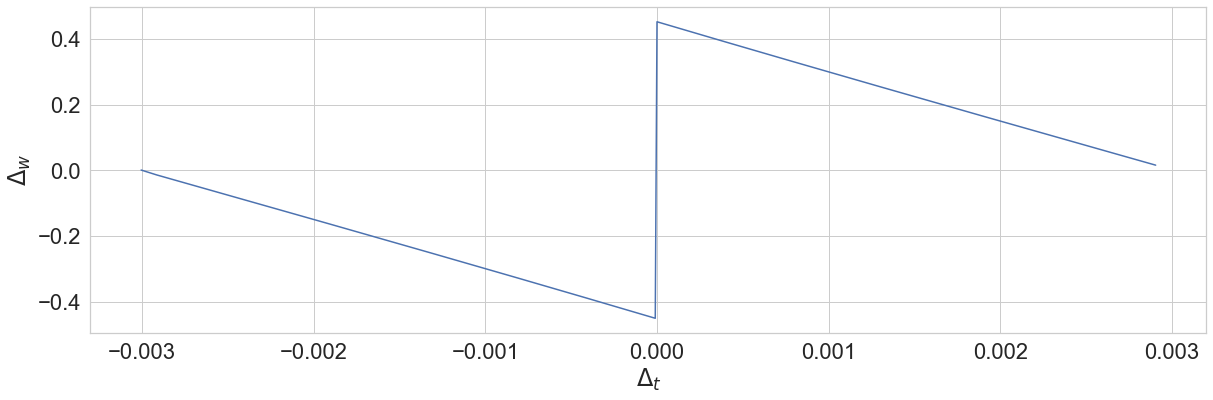

In [22]:
sorted_x, sorted_y,  = zip(*sorted(zip(signed_dts, dw_stdp_pot)))
plt.figure(figsize=(20, 6))
plt.plot(sorted_x, sorted_y)
plt.xlabel("$\Delta_t$")
plt.ylabel("$\Delta_w$");
plt.savefig("vdsp_maths_dt_vs_dw.svg", bbox_inches="tight")

In [23]:
dtp = np.abs(np.log((-1-current)/(mem_pot-current)))
dtn = np.abs(np.log((1-current)/(mem_pot-current)))

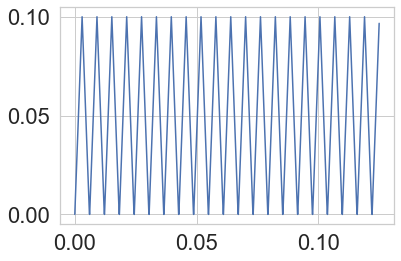

In [24]:
plt.plot(time, np.min((dtp, dtn), axis=0))

In [25]:
@np.vectorize
def fun_post_bseline(w, vmem, alpha=1, lr=1, dead_zone=0):
    vapp = -vmem
    f_pot = np.exp(-alpha*w)*(-w+1)
    f_dep = np.exp(alpha*(w-1))*w
    cond_pot = vapp > dead_zone
    cond_dep = vapp < -dead_zone
    g_pot = np.exp(vapp-dead_zone)-1
    g_dep = np.exp(-vapp-dead_zone)-1
    
    dW = cond_pot*f_pot*g_pot - cond_dep*f_dep*g_dep
    return dW * lr

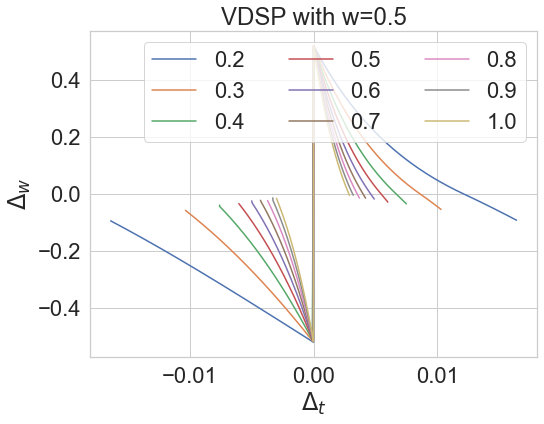

In [31]:
plt.figure(figsize=(8, 6))

for current in np.linspace(2, 10, 9):
    mem_pot, spikes = run_simul()
    dtn = np.log((vth - current) / (mem_pot - current))
    dtp = np.log((vreset - current) / (mem_pot - current))
    dts = tau_m*np.min((np.abs(dtn), np.abs(dtp)), axis=0)
    signs = np.sign(np.diff(dts))
    signed_dts = signs*dts[:-1]
    dw_vdsp = fun_post_bseline(0.5, mem_pot)
    sorted_x, sorted_y,  = zip(*sorted(zip(signed_dts, dw_vdsp)))
    plt.plot(sorted_x, sorted_y, label=current/10)

plt.legend(ncol=3)
plt.xlabel("$\Delta_t$")
plt.ylabel("$\Delta_w$");
plt.title(f"VDSP with {w=}")
plt.savefig("vdsp_shape_vs_current_no_dead_zone.svg", bbox_inches="tight")

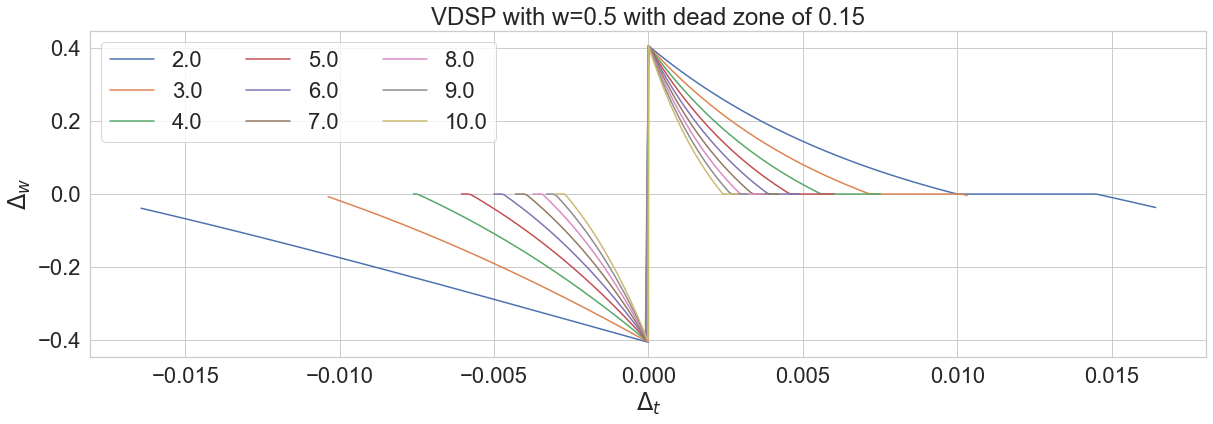

In [25]:
plt.figure(figsize=(20, 6))

dead_zone=0.15

for current in np.linspace(2, 10, 9):
    mem_pot, spikes = run_simul()
    dtn = np.log((vth - current) / (mem_pot - current))
    dtp = np.log((vreset - current) / (mem_pot - current))
    dts = tau_m*np.min((np.abs(dtn), np.abs(dtp)), axis=0)
    signs = np.sign(np.diff(dts))
    signed_dts = signs*dts[:-1]
    dw_vdsp = fun_post_bseline(0.5, mem_pot, dead_zone=0.15)
    sorted_x, sorted_y,  = zip(*sorted(zip(signed_dts, dw_vdsp)))
    plt.plot(sorted_x, sorted_y, label=current)

plt.legend(ncol=3)
plt.xlabel("$\Delta_t$")
plt.ylabel("$\Delta_w$");
plt.title(f"VDSP with {w=} with dead zone of {dead_zone}")
plt.savefig("vdsp_shape_vs_current_dead_zone.svg", bbox_inches="tight")